In [278]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [279]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [280]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a53141198>,
      dtype=object)

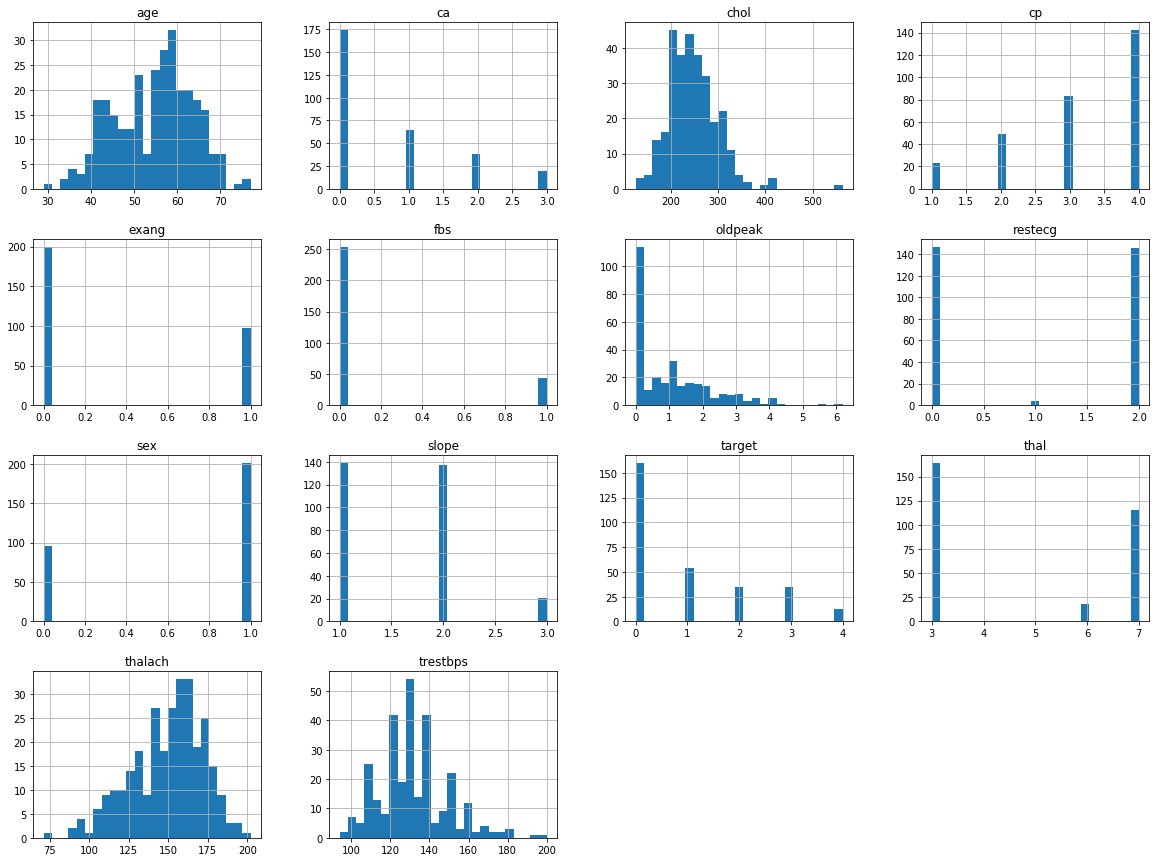

In [281]:
# raw_data = pd.read_csv("data/heart.csv")
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()

raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)
raw_data.hist(bins=25, figsize=(20,15))

In [282]:
# Categorical Types:
# Binary: sex, exang, fbs
# Multiclass: cp, restecg, thal

numerical_cols = ["age","trestbps","chol","thalach","slope","ca","oldpeak"]

original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_data = pd.get_dummies(original_data, 
                               columns=["cp","restecg","thal"],
                               prefix=["cp","restecg","thal"])


original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
0,63,1,145,233,1,150,0,3,0,2.3,1,0,0,0,0,0,1,0,1,0
1,67,1,160,286,0,108,1,2,3,1.5,0,0,0,1,0,0,1,1,0,0
2,67,1,120,229,0,129,1,2,2,2.6,0,0,0,1,0,0,1,0,0,1
3,37,1,130,250,0,187,0,3,0,3.5,0,0,1,0,1,0,0,1,0,0
4,41,0,130,204,0,172,0,1,0,1.4,0,1,0,0,0,0,1,1,0,0


In [283]:
original_data.shape

(297, 20)

In [284]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

#     dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 25, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units = 25, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [285]:
## Need to define a scaling function that ignores categorical values...?

In [286]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                525       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,227
Trainable params: 1,227
Non-trainable params: 0
_________________________________________________________________


In [287]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

In [622]:
nn = build_dnn(num_features=original_data.shape[1])
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)
_, correct_pred_idxs = pipeline.train_clusterer(class_label=1, plot=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.456, Acc:0.8953
Prediction Accuracy
28/28 [==============================] - 0s 2ms/step
Scores on data set: loss=0.553 accuracy=0.8214
Fold Correct: 23
Running worker: 1
Fold: 1 -> Loss:0.466, Acc:0.8876
Prediction Accuracy
28/28 [==============================] - 0s 14us/step
Scores on data set: loss=0.456 accuracy=0.8571
Fold Correct: 24
Running worker: 2
Fold: 2 -> Loss:0.439, Acc:0.8798
Prediction Accuracy
28/28 [==============================] - 0s 14us/step
Scores on data set: loss=0.686 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.474, Acc:0.8837
Prediction Accuracy
27/27 [==============================] - 0s 15us/step
Scores on data set: loss=0.635 accuracy=0.8148
Fold Correct: 22
Running worker: 4
Fold: 4 -> Loss:0.464, Acc:0.8885
Prediction Accuracy
26/26 [==============================] - 0s 15us/step
Scores on data set: loss=1.117 accuracy=0.6538
Fold Correct: 17
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.88194444 0.11805556]
 [0.21138211 0.78861789]]
Overall Accuracy: 0.8390


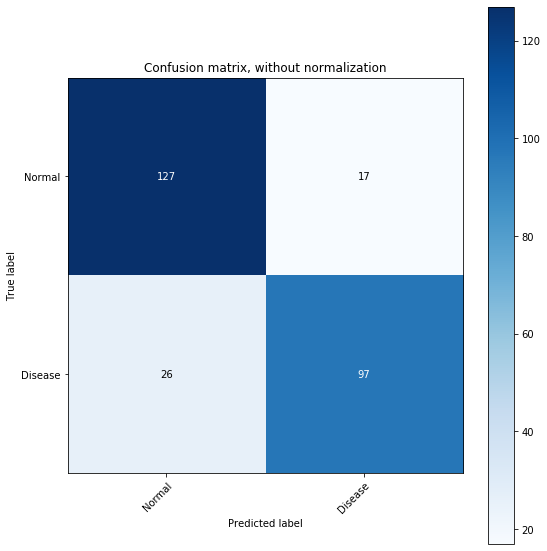

In [623]:
_, cm = plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [624]:
# correct_pred_idxs = sample_idxs
correct_pred_idxs[pipeline.clusterer.labels_ == 0].sort_values()

Int64Index([  8,   9,  29,  36,  37,  38,  45,  47,  54,  55,  60,  68,  76,
             79,  83,  94,  95, 105, 106, 107, 108, 109, 110, 112, 113, 118,
            122, 126, 135, 136, 137, 142, 152, 153, 155, 168, 173, 175, 178,
            186, 204, 225, 226, 228, 233, 234, 243, 244, 248, 261, 262, 264,
            276, 278, 280, 287, 292],
           dtype='int64')

In [607]:
nn2 = build_dnn(num_features=original_data.shape[1])
pipeline2 = ClusterPipeline(nn2, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)
pipeline2.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)
_, correct_pred_idxs2 = pipeline2.train_clusterer(class_label=1, plot=False)
_ = pipeline2.get_validation_clusters()

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.453, Acc:0.9031
Prediction Accuracy
28/28 [==============================] - 0s 2ms/step
Scores on data set: loss=0.511 accuracy=0.8214
Fold Correct: 23
Running worker: 1
Fold: 1 -> Loss:0.467, Acc:0.8953
Prediction Accuracy
28/28 [==============================] - 0s 20us/step
Scores on data set: loss=0.471 accuracy=0.8214
Fold Correct: 23
Running worker: 2
Fold: 2 -> Loss:0.458, Acc:0.8837
Prediction Accuracy
28/28 [==============================] - 0s 20us/step
Scores on data set: loss=0.721 accuracy=0.8214
Fold Correct: 23
Running worker: 3
Fold: 3 -> Loss:0.464, Acc:0.8915
Prediction Accuracy
27/27 [==============================] - 0s 18us/step
Scores on data set: loss=0.660 accuracy=0.8519
Fold Correct: 23
Running worker: 4
Fold: 4 -> Loss:0.443, Acc:0.9000
Prediction Accuracy
26/26 [==============================] - 0s 26us/step
Scores on data set: loss=1.134 accuracy=0.6923
Fold Correct: 18
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.88194444 0.11805556]
 [0.19512195 0.80487805]]
Overall Accuracy: 0.8464


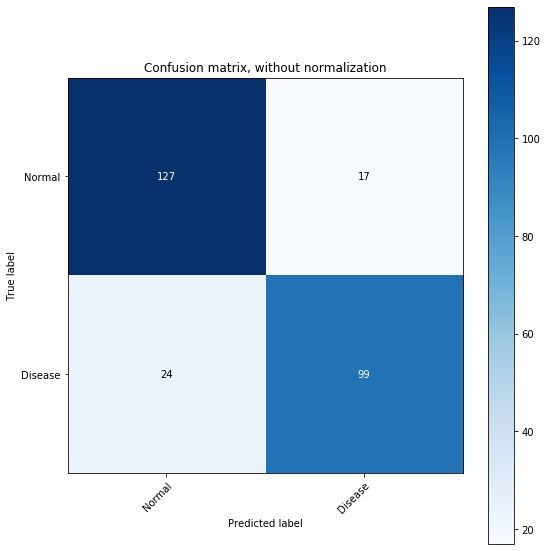

In [608]:
_, cm = plot_confusion_matrix(y_train.values[pipeline2.testing_idxs], np.array(pipeline2.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [625]:
pd.Series(pipeline.clusterer.labels_).value_counts()

0    57
1    40
dtype: int64

In [626]:
pd.Series(pipeline2.clusterer.labels_).value_counts()

0    59
1    40
dtype: int64

In [627]:
# Isolating samples that were predicted by one but not both
not_in_common = set(correct_pred_idxs) ^ set(correct_pred_idxs2)
print("Run 1 failed to predict:", set(correct_pred_idxs2) - set(correct_pred_idxs))
print("Run 2 failed to predict:", set(correct_pred_idxs) - set(correct_pred_idxs2))

Run 1 failed to predict: {16, 56, 208}
Run 2 failed to predict: {106}


In [628]:
_set0 = set(correct_pred_idxs[pipeline.clusterer.labels_ == 0])
_set1 = set(correct_pred_idxs[pipeline.clusterer.labels_ == 1])
cluster_sets0 = set(correct_pred_idxs2[pipeline2.clusterer.labels_ == 0])
cluster_sets1 = set(correct_pred_idxs2[pipeline2.clusterer.labels_ == 1])

# We expect both runs to have "most" samples in clusters ot be common

In [629]:
prev_min = [len(X_train), len(X_train)]
common_pair = [None, None]
# ^ = symmetric_difference()

for i, s1 in enumerate([_set0,_set1]):
    for j,s2 in enumerate([cluster_sets0,cluster_sets1]):
        
        if len(s1 ^ s2) < prev_min[i]:
            common_pair[i] = (s1,s2)
            print("Pair:",i,j)
        prev_min[i] = len(s1 ^ s2)
#         print(i,(s1 ^ s2))

for s1,s2 in common_pair:
    print("Common Ratio: {:.4f}".format(len(s1&s2)/len(s1|s2)))
    print("Corrected Ratio: {:.4f}".format(len(s1&s2)/len((s1|s2)-not_in_common)))

Pair: 0 0
Pair: 1 0
Pair: 1 1
Common Ratio: 0.9333
Corrected Ratio: 1.0000
Common Ratio: 1.0000
Corrected Ratio: 1.0000


### Note that removing not_in_common from the symmetric difference results in the samples that "jumped" clusters OR put into Noise

In [635]:
for i,(s1,s2) in enumerate(common_pair):
    print("Unshared Samples in Cluster {}: {}".format(i,s1.symmetric_difference(s2) - not_in_common))

Unshared Samples in Cluster 0: set()
Unshared Samples in Cluster 1: set()


In [636]:
pipeline.testing_idxs == pipeline2.testing_idxs

True

In [637]:
# Internally populates self.val_set_lrp
samples, cluster_labels = pipeline.get_validation_clusters()

Prediction Accuracy: 0.8333


## Plotting Relevance Clusters

In [644]:
def plot_clusters(pipeline):
    training_lrp = pipeline.training_lrp
    val_lrp = pipeline.val_set_lrp
    # pipeline.reducer_pipeline[0].n_neighbors
    embedding_pipeline = Pipeline([
        ("reducer", umap.UMAP(random_state=42,
                        n_components = 3,
                        n_neighbors=10,
                        min_dist=0)),
       ("scaler", MinMaxScaler())
    ])
    embedding_pipeline.fit(training_lrp)

    embedding = embedding_pipeline.transform(training_lrp)

    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Training",
        marker=dict(
            size=5,
            color=pipeline.clusterer.labels_,
            colorscale="Rainbow",
            opacity=0.8
        ),
        text=pipeline.clusterer.labels_
    )

    val_3d_embedding = embedding_pipeline.transform(val_lrp)

    val_emb3d = go.Scatter3d(
        x=val_3d_embedding[:,0],
        y=val_3d_embedding[:,1],
        z=val_3d_embedding[:,2],
        name="Validation",
        mode="markers",
        marker=dict(
            size=5,
            color=cluster_labels,
            colorscale='Viridis',
            opacity=0.8
    #         showscale=True
        ),
        text = cluster_labels
    )

    layout = go.Layout(
        title="3D LRP Embedding",
        autosize=False,
        width=1200,
        height=1000,
        paper_bgcolor='#F5F5F5',
    #     template="plotly"
    )


    data=[emb3d, val_emb3d]

    fig = go.Figure(data=data, layout=layout)
    # fig.update_layout(template="plotly")  /

    iplot(fig, filename='lrp-3d-scatter.html')

In [645]:
samples, cluster_labels = pipeline.get_validation_clusters()
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp
training_lrp.shape

plot_clusters(pipeline)
plot_clusters(pipeline2)

# Performing Feature Reduction

In [646]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.7) <= thresh)

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

## Getting correctly predictied samples form target class

In [647]:
subcluster_labels = range(0,max(pipeline.clusterer.labels_)+1)

# Get testing samples from cross validation
reindexer = pipeline.testing_idxs

# That were correctly predicted
correct_preds = pipeline.correct_preds_bool_arr

# Separating Control from Target
target_samples  = y_train.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

target_class_features = X_train.iloc[reindexer][correct_preds][target_samples]
target_class_labels   = y_train.iloc[reindexer][correct_preds][target_samples]
target_class_features.head()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
122,55,1,140,217,0,111,1,3,0,5.6,0,0,0,1,1,0,0,0,0,1
24,60,1,130,206,0,132,1,2,2,2.4,0,0,0,1,0,0,1,0,0,1
137,35,1,120,198,0,130,1,2,0,1.6,0,0,0,1,1,0,0,0,0,1
79,58,1,150,270,0,111,1,1,0,0.8,0,0,0,1,0,0,1,0,0,1
120,63,0,150,407,0,154,0,2,3,4.0,0,0,0,1,0,0,1,0,0,1


In [650]:
target_class_features.shape

(97, 20)

In [651]:
target_size = len(target_class_labels)
control_features = X_train[y_train != pipeline.target_class][:target_size]
# control_features = control_features[:target_size]
control_labels = y_train[y_train != pipeline.target_class][:target_size]

correct_predictions_features = pd.concat([control_features, target_class_features], axis="index")
correct_predictions_labels = pd.concat([control_labels, target_class_labels], axis="index")

## Using reduced features for retraining

> **Only values from the same cluster can be retrained**

### Lets set a more restrictive threshold

In [652]:
_clustered.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.0,58.000000,58.000000,58.000000,58.000000
mean,0.013110,0.137012,0.126644,0.047360,0.014907,0.101041,0.213251,0.229680,0.095138,0.194598,0.034409,0.005069,0.110709,0.240250,0.038881,0.0,0.029149,0.170990,0.011229,0.268760
std,0.029700,0.064659,0.230833,0.080560,0.017523,0.109951,0.149364,0.219488,0.096446,0.230430,0.016295,0.025081,0.062243,0.130756,0.043580,0.0,0.040645,0.090825,0.011655,0.160990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.115132,0.000000,0.000000,0.000155,0.008178,0.000000,0.147607,0.000000,0.000000,0.023167,0.000000,0.087921,0.209197,0.000000,0.0,0.000000,0.122457,0.000000,0.186694
50%,0.000000,0.147340,0.000000,0.002925,0.009458,0.063875,0.251868,0.180168,0.114472,0.088281,0.033797,0.000000,0.111979,0.245840,0.028550,0.0,0.000000,0.173004,0.008993,0.301831
75%,0.014774,0.185568,0.166361,0.060914,0.024390,0.161186,0.348815,0.274440,0.159633,0.334185,0.042907,0.000000,0.122996,0.330440,0.068776,0.0,0.050716,0.216312,0.015773,0.372869
max,0.159987,0.263175,1.181409,0.362503,0.086538,0.503900,0.421240,1.025693,0.358151,0.829284,0.071638,0.168853,0.281773,0.455178,0.144289,0.0,0.137872,0.335830,0.047764,0.568028


In [655]:
# _clustered.quantile(0.7) <= _clustered.mean()

In [656]:
# _clustered.mean().describe()

Thresh: 0.03265412524342537
Index(['sex', 'trestbps', 'fbs', 'exang', 'slope', 'ca', 'oldpeak', 'cp_1',
       'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3', 'thal_7'],
      dtype='object') 14
Thresh: 0.02214532755315304
Index(['sex', 'trestbps', 'chol', 'fbs', 'exang', 'slope', 'ca', 'oldpeak',
       'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3', 'thal_7'],
      dtype='object') 15


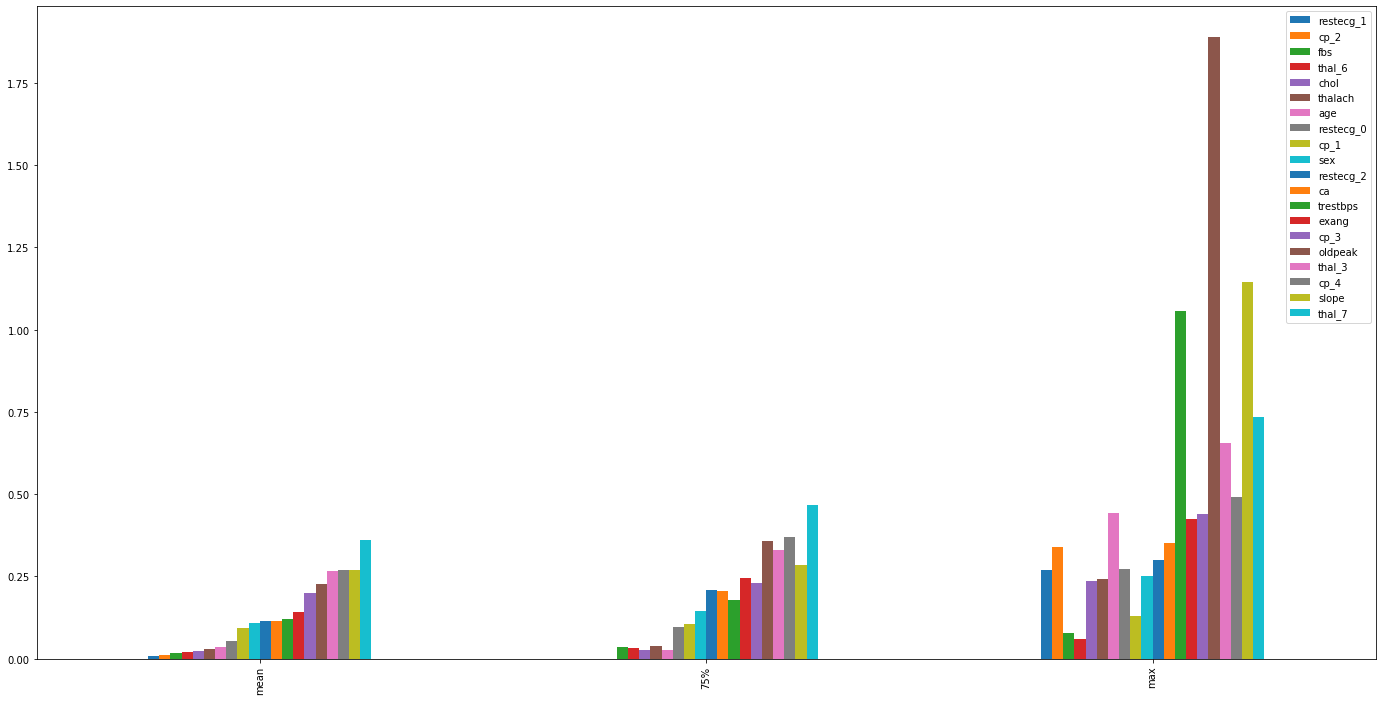

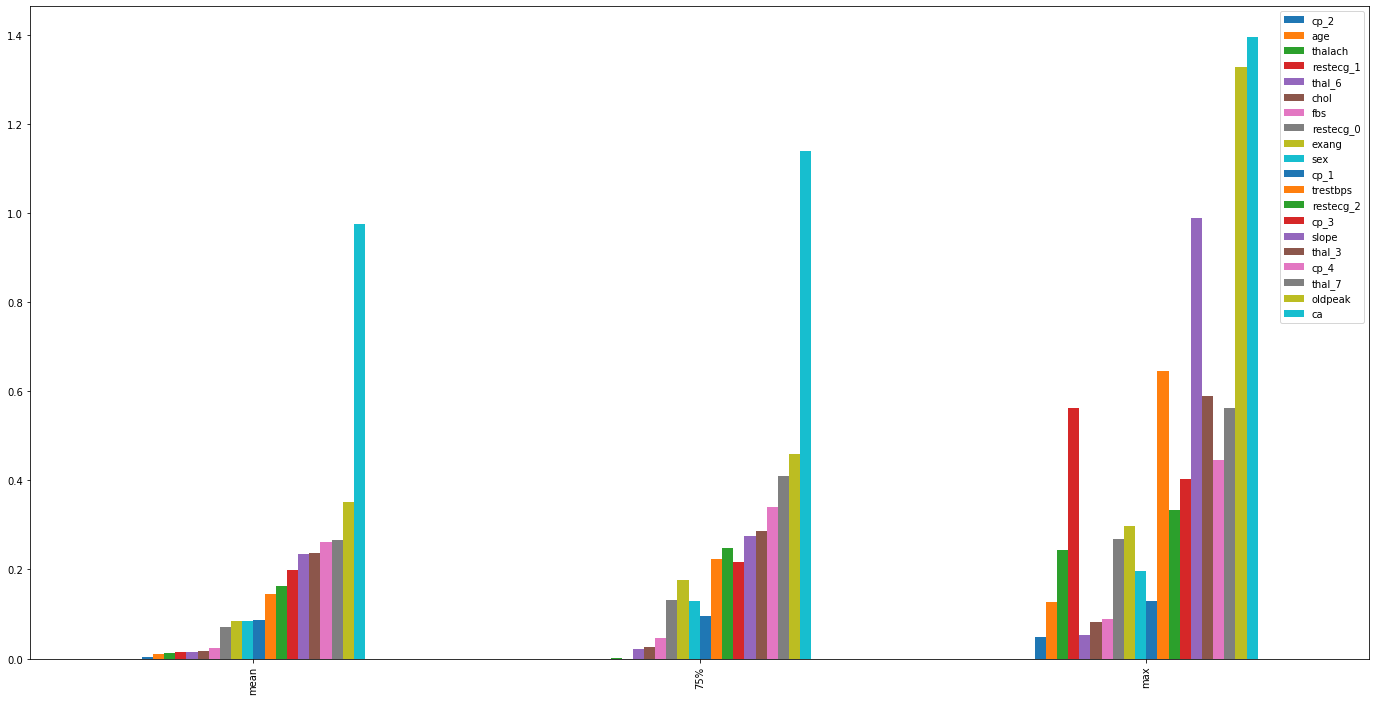

In [657]:
cluster_train = {}

for cluster_label in subcluster_labels:
    
    tsamples = target_class_features[(pipeline.clusterer.labels_ == cluster_label)]
    tlabels  = target_class_labels[(pipeline.clusterer.labels_ == cluster_label)]

#     csamples = X_train.iloc[reindexer][correct_preds][control_samples]
    csamples = X_train[y_train != pipeline.target_class]
    csamples = csamples[:len(tsamples)]

#     clabels = y_train.iloc[reindexer][correct_preds][control_samples]
    clabels = y_train[y_train != pipeline.target_class]
    clabels = clabels[:len(tsamples)]
    
    _clustered = pd.DataFrame(pipeline.training_lrp[(pipeline.clusterer.labels_ == cluster_label)],
                              columns = X_train.columns)
#     print(_clustered.describe())
    srtd_metrics = _clustered.describe().loc[["mean","75%","max"]].sort_values(by=["mean", "75%", "max"], axis=1)
    srtd_metrics.plot(kind="bar", figsize=(24,12))
    
    thresh = _clustered.mean().quantile(0.3)
#     thresh = _clustered.quantile(0.8).quantile(0.5)
    print("Thresh:", thresh)
    reduced_cols = get_relevant_cols(_clustered, thresh=thresh).columns
    print(reduced_cols, len(reduced_cols))
    
    tsamples = tsamples[reduced_cols]
    csamples  = csamples[reduced_cols]
    
    # Now stack it with control values of same size...
    X_train_sc = pd.concat([csamples, tsamples], axis="index")
    y_train_sc = pd.concat([clabels, tlabels], axis="index")
    
#     print("Combined:", all(X_train_sc.index == y_train_sc.index))
    
    cluster_train[cluster_label] = (X_train_sc, y_train_sc)


### Baseline CN vs Subcluster

> **Reusing the same network architecture may not be valid as the samples are already biased towards it**

In [658]:
def runSubclusterAnalysis(cluster_train, dnn_build_fn, batch_size=20, epochs=100):
    results = {}
    pipelines = {}
    
    for sc in cluster_train:
        X_train_sc, y_train_sc = cluster_train[sc]

        X_val_sc, y_val_sc = cluster_train[(sc+1)%len(cluster_train)]

        target_sc_idx = X_val_sc[y_val_sc == pipeline.target_class].index

        X_val_sc = target_class_features[X_train_sc.columns].reindex(target_sc_idx)
        y_val_sc = target_class_labels.reindex(target_sc_idx)

        nn = dnn_build_fn(num_features=X_train_sc.shape[1])

        _pipeline = ClusterPipeline(nn, [X_train_sc, y_train_sc], [X_val_sc, y_val_sc], target_class=1)
        _pipeline.train_model(batch_size=batch_size,epochs=epochs, cross_validation=True, parallel=False, verbose=0)

        _, cm = plot_confusion_matrix(y_train_sc.values[_pipeline.testing_idxs],
                              np.array(_pipeline.predictions, dtype=int),
                              np.array(["Normal", "Disease"]))
        results[sc] = cm
        pipelines[sc] = _pipeline
        print("------- Validating ---------")
        _pipeline.get_predictions()
        print("------- ---------- ---------")
    
    print("======"*10)
    correct = sum([np.trace(results[sc]) for sc in results])
    total   = sum([sum(results[sc].ravel()) for sc in results])
    print("Analysis Accuracy: {:.4f}".format(correct/total))
    
    
    return results, pipelines

In [659]:
non_red_cluster_train = pipeline.getSubclusters(reduce=False)

# %time baseline_results = runSubclusterAnalysis(non_red_cluster_train, build_dnn)

# Feeding models (feature) reduced data

In [660]:
cluster_train = pipeline.getSubclusters(reduce=True)
sc0_features = set(cluster_train[0][0].columns)
sc1_features = set(cluster_train[1][0].columns)

print(sc0_features, len(sc0_features))
print(sc1_features, len(sc1_features))

0.11213591694831848
0.08580321073532104
{'exang', 'restecg_2', 'ca', 'thal_7', 'cp_3', 'sex', 'oldpeak', 'thal_3', 'trestbps', 'cp_4', 'slope'} 11
{'cp_1', 'exang', 'restecg_2', 'ca', 'thal_7', 'cp_3', 'sex', 'restecg_0', 'oldpeak', 'thal_3', 'trestbps', 'cp_4', 'slope'} 13


## Original architecture

### Accuracy is same as w/ original feature set
> **This is a sign that the features dropped were in fact not very useful for classifying *this* subcluster**

In [661]:
# %time baseline_reduced_results = runSubclusterAnalysis(cluster_train, build_dnn)

# Shallow Network

## Rebuilding a (simpler) DNN architecture

In [662]:
def build_shallow_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 15, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 10, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=5, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

### Accuracy is same as w/ original architecture

- **Using a different network architecture removes any potential sources of bias of reusing the same samples for the same network**
- **Using a shallower n/w shows us that a "simpler" classifier can work**

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.286, Acc:0.9314
Prediction Accuracy
12/12 [==============================] - 0s 4ms/step
Scores on data set: loss=0.179 accuracy=1.0000
Fold Correct: 12
Running worker: 1
Fold: 1 -> Loss:0.275, Acc:0.9216
Prediction Accuracy
12/12 [==============================] - 0s 33us/step
Scores on data set: loss=0.253 accuracy=0.9167
Fold Correct: 11
Running worker: 2
Fold: 2 -> Loss:0.389, Acc:0.8922
Prediction Accuracy
12/12 [==============================] - 0s 49us/step
Scores on data set: loss=0.138 accuracy=1.0000
Fold Correct: 12
Running worker: 3
Fold: 3 -> Loss:0.273, Acc:0.9118
Prediction Accuracy
12/12 [==============================] - 0s 38us/step
Scores on data set: loss=0.390 accuracy=0.8333
Fold Correct: 10
Running worker: 4
Fold: 4 -> Loss:0.329, Acc:0.9118
Prediction Accuracy
12/12 [==============================] - 0s 50us/step
Scores on data set: loss=0.481 accuracy=0.8333
Fold Correct: 10
Running worker: 5
Fo

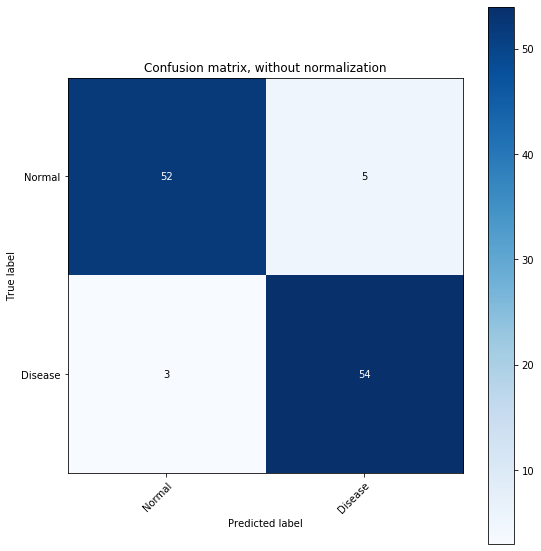

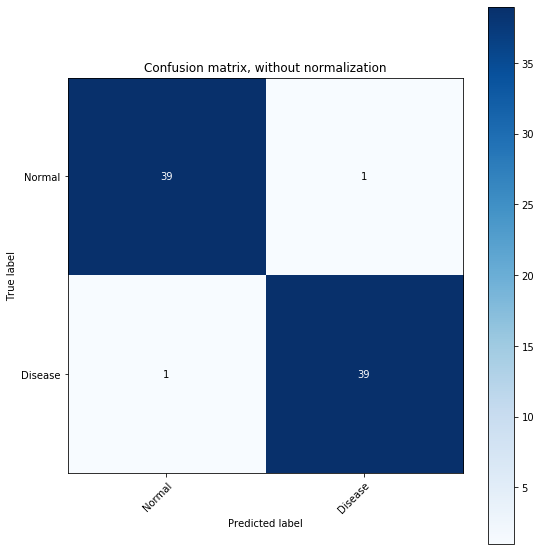

In [663]:
%time shallow_nw_results, pipelines = runSubclusterAnalysis(cluster_train, build_shallow_dnn, batch_size=20, epochs=30)

In [573]:
# Doesnt work possibly due to keras graph issues
# pipelines[0].foldmodel(0)

In [499]:
# sc = 1
# print("Validating C_{}:".format(sc))
# X_train_sc, y_train_sc = cluster_train[sc]
# X_val_sc, y_val_sc = cluster_train[(sc+1)%len(cluster_train)]

# target_sc_idx = X_val_sc[y_val_sc == pipeline.target_class].index

# X_val_sc = target_class_features[X_train_sc.columns].reindex(target_sc_idx)
# y_val_sc = target_class_labels.reindex(target_sc_idx)

# pipelines[sc].val_set = ClusterPipeline.Dataset(X_val_sc, y_val_sc)
# pipelines[sc].get_predictions()

In [665]:
# correct = sum([np.trace(shallow_nw_results[sc]) for sc in shallow_nw_results])
# total = sum([sum(shallow_nw_results[sc].ravel()) for sc in shallow_nw_results])
# print("Analysis Accuracy: {:.4f}".format(correct/total))

- ### Better accuracy than original architecure being fed reduced features
- # Generally beats original non-subclustered analysis
- ### Not as good as orginal with subclustered data
    - **Thats expected however due to the implicit bias in the subclusters**


## NN w/ ALL features
- ### Performs just as well as original architecure with subcluster

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.388, Acc:0.9020
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.330 accuracy=0.9167
Fold Correct: 11
Running worker: 1
Fold: 1 -> Loss:0.431, Acc:0.8627
Prediction Accuracy
12/12 [==============================] - 0s 28us/step
Scores on data set: loss=0.307 accuracy=0.9167
Fold Correct: 11
Running worker: 2
Fold: 2 -> Loss:0.306, Acc:0.9412
Prediction Accuracy
12/12 [==============================] - 0s 39us/step
Scores on data set: loss=0.352 accuracy=0.9167
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.364, Acc:0.8824
Prediction Accuracy
12/12 [==============================] - 0s 48us/step
Scores on data set: loss=0.199 accuracy=1.0000
Fold Correct: 12
Running worker: 4
Fold: 4 -> Loss:0.311, Acc:0.9020
Prediction Accuracy
12/12 [==============================] - 0s 45us/step
Scores on data set: loss=0.863 accuracy=0.9167
Fold Correct: 11
Running worker: 5
Fo

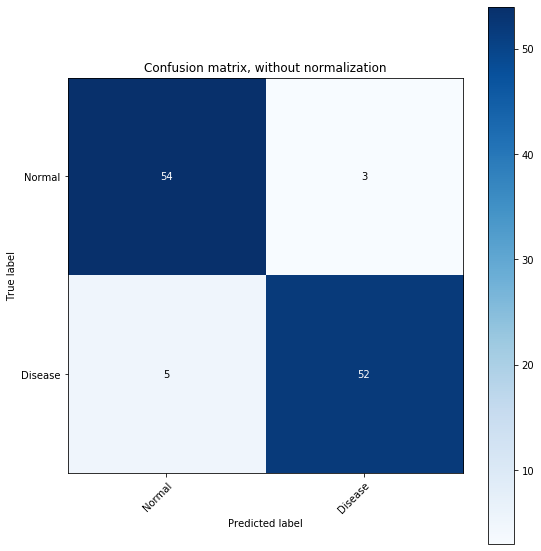

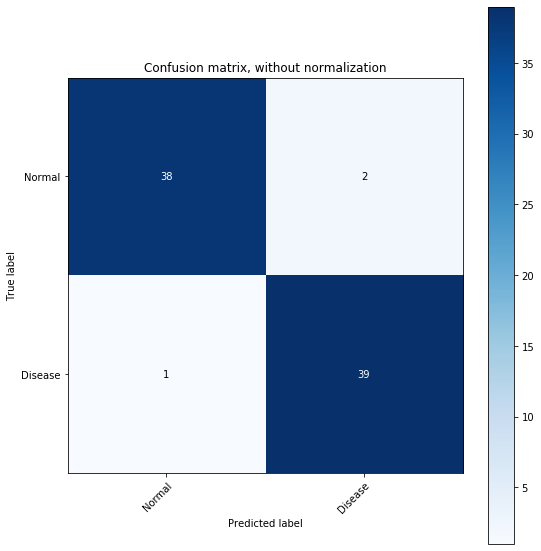

In [666]:
# non_red_cluster_train = pipeline.getSubclusters(reduce=False)
%time shallow_nw_results = runSubclusterAnalysis(non_red_cluster_train, build_shallow_dnn, batch_size=20, epochs=30)

## NN w/ well biased (well-separated) samples
> ### *Target Samples* that were correctly predicted by the DNN

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.315, Acc:0.9138
Prediction Accuracy
20/20 [==============================] - 0s 2ms/step
Scores on data set: loss=0.204 accuracy=0.9500
Fold Correct: 19
Running worker: 1
Fold: 1 -> Loss:0.241, Acc:0.9483
Prediction Accuracy
20/20 [==============================] - 0s 21us/step
Scores on data set: loss=0.663 accuracy=0.8500
Fold Correct: 17
Running worker: 2
Fold: 2 -> Loss:0.260, Acc:0.9483
Prediction Accuracy
20/20 [==============================] - 0s 25us/step
Scores on data set: loss=0.133 accuracy=1.0000
Fold Correct: 20
Running worker: 3
Fold: 3 -> Loss:0.242, Acc:0.9253
Prediction Accuracy
20/20 [==============================] - 0s 24us/step
Scores on data set: loss=0.494 accuracy=0.9500
Fold Correct: 19
Running worker: 4
Fold: 4 -> Loss:0.290, Acc:0.9138
Prediction Accuracy
20/20 [==============================] - 0s 29us/step
Scores on data set: loss=0.229 accuracy=0.9500
Fold Correct: 19
Running worker: 5
Fo

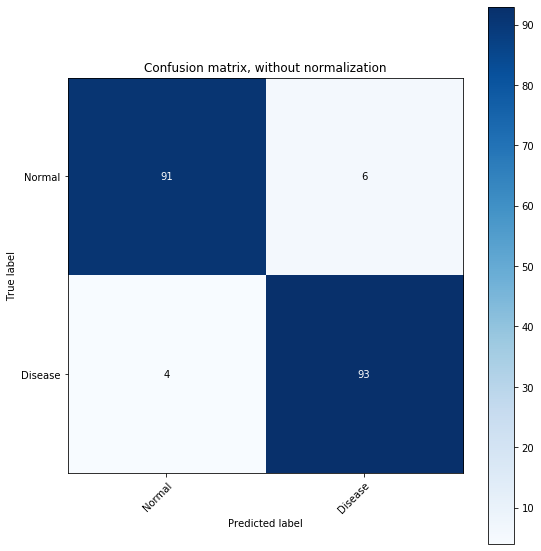

In [667]:
nn = build_shallow_dnn(num_features=X_train.shape[1])

shallow_pipeline = ClusterPipeline(nn, [correct_predictions_features, correct_predictions_labels], [X_valid, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=20,epochs=30, cross_validation=True, parallel=False, verbose=0)

_,cm = plot_confusion_matrix(correct_predictions_labels.values[shallow_pipeline.testing_idxs],
                             np.array(shallow_pipeline.predictions, dtype=int),
                             np.array(["Normal", "Disease"]))
_ = shallow_pipeline.get_predictions()

## Shallow on Original Data

In [668]:
nn = build_shallow_dnn(num_features=X_train.shape[1])

shallow_pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=20,epochs=30, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.480, Acc:0.8488
Prediction Accuracy
28/28 [==============================] - 0s 2ms/step
Scores on data set: loss=0.385 accuracy=0.8571
Fold Correct: 24
Running worker: 1
Fold: 1 -> Loss:0.508, Acc:0.8101
Prediction Accuracy
28/28 [==============================] - 0s 15us/step
Scores on data set: loss=0.455 accuracy=0.8214
Fold Correct: 23
Running worker: 2
Fold: 2 -> Loss:0.451, Acc:0.8605
Prediction Accuracy
28/28 [==============================] - 0s 19us/step
Scores on data set: loss=0.601 accuracy=0.8214
Fold Correct: 23
Running worker: 3
Fold: 3 -> Loss:0.499, Acc:0.8333
Prediction Accuracy
27/27 [==============================] - 0s 14us/step
Scores on data set: loss=0.494 accuracy=0.8889
Fold Correct: 24
Running worker: 4
Fold: 4 -> Loss:0.446, Acc:0.8500
Prediction Accuracy
26/26 [==============================] - 0s 15us/step
Scores on data set: loss=0.856 accuracy=0.6538
Fold Correct: 17
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.88888889 0.11111111]
 [0.21138211 0.78861789]]
Overall Accuracy: 0.8427


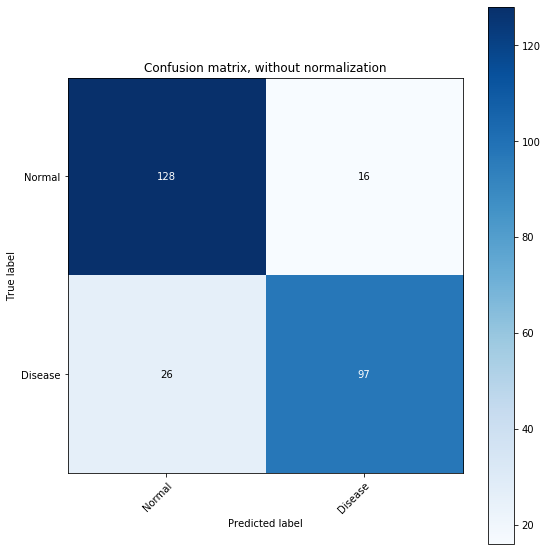

In [669]:
_,cm = plot_confusion_matrix(y_train.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## Shallow on original data w/ reduced combined features

In [674]:
combined_features = sc1_features.union(sc0_features)
print(combined_features, len(combined_features))

{'exang', 'ca', 'sex', 'oldpeak', 'restecg_2', 'slope', 'thal_7', 'cp_3', 'restecg_0', 'cp_1', 'thal_3', 'trestbps', 'cp_4'} 13


In [671]:
# X_train[combined_features]

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.511, Acc:0.8140
Prediction Accuracy
28/28 [==============================] - 0s 2ms/step
Scores on data set: loss=0.361 accuracy=0.8929
Fold Correct: 25
Running worker: 1
Fold: 1 -> Loss:0.533, Acc:0.8062
Prediction Accuracy
28/28 [==============================] - 0s 13us/step
Scores on data set: loss=0.435 accuracy=0.8571
Fold Correct: 24
Running worker: 2
Fold: 2 -> Loss:0.530, Acc:0.8178
Prediction Accuracy
28/28 [==============================] - 0s 16us/step
Scores on data set: loss=0.496 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.526, Acc:0.8101
Prediction Accuracy
27/27 [==============================] - 0s 16us/step
Scores on data set: loss=0.442 accuracy=0.8889
Fold Correct: 24
Running worker: 4
Fold: 4 -> Loss:0.455, Acc:0.8269
Prediction Accuracy
26/26 [==============================] - 0s 20us/step
Scores on data set: loss=0.810 accuracy=0.6923
Fold Correct: 18
Running worker: 5
Fo

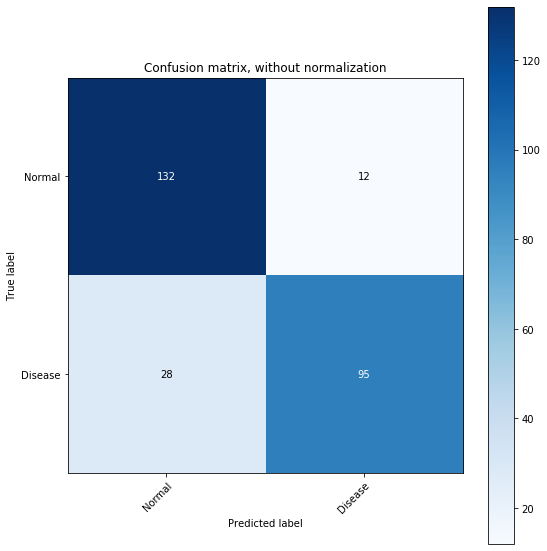

In [672]:
_X_train_red = X_train[combined_features]
_X_valid_red = X_valid[combined_features]

nn = build_shallow_dnn(num_features=_X_train_red.shape[1])

shallow_pipeline = ClusterPipeline(nn, [_X_train_red, y_train], [_X_valid_red, y_valid], target_class=1)
shallow_pipeline.train_model(batch_size=20,epochs=30, cross_validation=True, parallel=False, verbose=0)
_,cm = plot_confusion_matrix(y_train.values[shallow_pipeline.testing_idxs],
                             np.array(shallow_pipeline.predictions, dtype=int),
                             np.array(["Normal", "Disease"]))
_ = shallow_pipeline.get_predictions()

## Biased Samples, feature reduced

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.242, Acc:0.9138
Prediction Accuracy
20/20 [==============================] - 0s 2ms/step
Scores on data set: loss=0.236 accuracy=0.9500
Fold Correct: 19
Running worker: 1
Fold: 1 -> Loss:0.223, Acc:0.9598
Prediction Accuracy
20/20 [==============================] - 0s 30us/step
Scores on data set: loss=0.282 accuracy=0.9000
Fold Correct: 18
Running worker: 2
Fold: 2 -> Loss:0.274, Acc:0.9080
Prediction Accuracy
20/20 [==============================] - 0s 29us/step
Scores on data set: loss=0.113 accuracy=1.0000
Fold Correct: 20
Running worker: 3
Fold: 3 -> Loss:0.245, Acc:0.9483
Prediction Accuracy
20/20 [==============================] - 0s 23us/step
Scores on data set: loss=0.482 accuracy=0.9000
Fold Correct: 18
Running worker: 4
Fold: 4 -> Loss:0.233, Acc:0.9310
Prediction Accuracy
20/20 [==============================] - 0s 32us/step
Scores on data set: loss=0.288 accuracy=0.9500
Fold Correct: 19
Running worker: 5
Fo

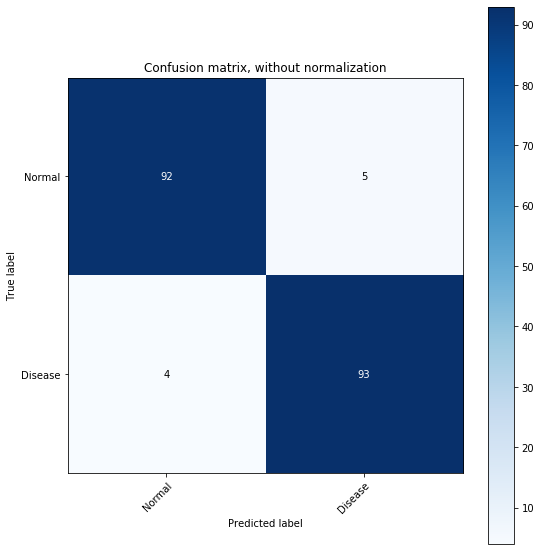

In [675]:
_X_train_red = correct_predictions_features[combined_features]
_X_valid_red = X_valid[combined_features]

nn = build_shallow_dnn(num_features=_X_train_red.shape[1])

shallow_pipeline = ClusterPipeline(nn, [_X_train_red, correct_predictions_labels], [_X_valid_red, y_valid], target_class=1)
shallow_pipeline.train_model(batch_size=20,epochs=30, cross_validation=True, parallel=False, verbose=0)
_,cm = plot_confusion_matrix(correct_predictions_labels.values[shallow_pipeline.testing_idxs],
                             np.array(shallow_pipeline.predictions, dtype=int),
                             np.array(["Normal", "Disease"]))
_ = shallow_pipeline.get_predictions()

## Original Architecure w/ reduced features

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.570, Acc:0.8682
Prediction Accuracy
28/28 [==============================] - 0s 2ms/step
Scores on data set: loss=0.529 accuracy=0.8571
Fold Correct: 24
Running worker: 1
Fold: 1 -> Loss:0.584, Acc:0.8527
Prediction Accuracy
28/28 [==============================] - 0s 13us/step
Scores on data set: loss=0.528 accuracy=0.8571
Fold Correct: 24
Running worker: 2
Fold: 2 -> Loss:0.598, Acc:0.8488
Prediction Accuracy
28/28 [==============================] - 0s 14us/step
Scores on data set: loss=0.641 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.618, Acc:0.8062
Prediction Accuracy
27/27 [==============================] - 0s 17us/step
Scores on data set: loss=0.589 accuracy=0.8519
Fold Correct: 23
Running worker: 4
Fold: 4 -> Loss:0.555, Acc:0.8885
Prediction Accuracy
26/26 [==============================] - 0s 17us/step
Scores on data set: loss=1.061 accuracy=0.6923
Fold Correct: 18
Running worker: 5
Fo

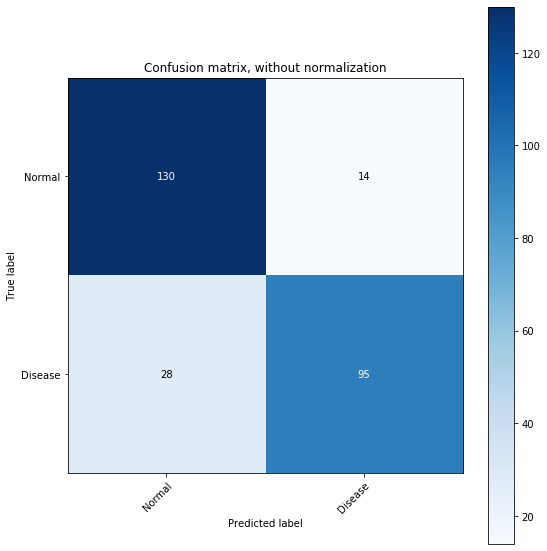

In [685]:
_X_train_red = X_train[combined_features]
_X_valid_red = X_valid[combined_features]

nn = build_dnn(num_features=_X_train_red.shape[1])

orig_pipeline = ClusterPipeline(nn, [_X_train_red, y_train], [_X_valid_red, y_valid], target_class=1)
orig_pipeline.train_model(batch_size=20,epochs=30, cross_validation=True, parallel=False, verbose=0)
_,cm = plot_confusion_matrix(y_train.values[orig_pipeline.testing_idxs],
                             np.array(orig_pipeline.predictions, dtype=int),
                             np.array(["Normal", "Disease"]))
_ = orig_pipeline.get_predictions()

# SVM Analysis

In [676]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()


clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC())
])

def runSVM(X,y, X_valid,y_valid):
    np.random.seed(42)
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(lsvc, param_grid, 
                                cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, _score.mean()

## SVM trained on original data

In [677]:
original_svm, score = runSVM(X_train, y_train, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.846(+/- 0.143)


## SVM trained on biased data -- Baseline
> Both subclusters vs control

In [678]:
original_svm, score = runSVM(correct_predictions_features, correct_predictions_labels, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.953(+/- 0.074)


### Reduced features

In [679]:
%%time
_X_train_red = correct_predictions_features[combined_features]
_X_valid_red = X_valid[combined_features]

original_svm, score = runSVM(_X_train_red, correct_predictions_labels, _X_valid_red, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.733
SVM CV Accuracy: 0.952(+/- 0.089)
CPU times: user 242 ms, sys: 6.64 ms, total: 248 ms
Wall time: 2.18 s


## Trained on subcluster vs control only

In [686]:
%%time 
scores = []
sizes = []

for sc in non_red_cluster_train:
    X_train_sc, y_train_sc = non_red_cluster_train[sc]
    
    X_val_sc, y_val_sc = cluster_train[(sc+1)%len(cluster_train)]

    target_sc_idx = X_val_sc[y_val_sc == pipeline.target_class].index

    X_val_sc = target_class_features[X_train_sc.columns].reindex(target_sc_idx)
    y_val_sc = target_class_labels.reindex(target_sc_idx)

    
    X_valid_red = X_valid[X_train_sc.columns]
    _clf, _score = runSVM(X_train_sc, y_train_sc, X_val_sc, y_val_sc)
    scores.append(_score)
    sizes.append(len(X_train_sc))

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 1.000
SVM CV Accuracy: 0.932(+/- 0.146)
{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.474
SVM CV Accuracy: 0.963(+/- 0.115)
CPU times: user 470 ms, sys: 111 ms, total: 581 ms
Wall time: 5.94 s


In [687]:
# This is actually the "true" mean: sum(correctly classified) / (total samples)
weighted_avg = sum([sz*sc.mean() for sz,sc in zip(sizes, scores)])/sum(sizes)
print("Weighted Mean: {:0.4f}".format(weighted_avg))

Weighted Mean: 0.9444


## Trained on feature reduced subcluster
> ### Despite losing some features, we still retain a high accuracy
> ### This may be an indication that the subclustering was infact a valid one

In [688]:
scores = []
sizes  = []

for sc in cluster_train:
    X_train_sc, y_train_sc = cluster_train[sc]
    
    X_val_sc, y_val_sc = cluster_train[(sc+1)%len(cluster_train)]
    target_sc_idx = X_val_sc[y_val_sc == pipeline.target_class].index
    X_val_sc = target_class_features[X_train_sc.columns].reindex(target_sc_idx)
    y_val_sc = target_class_labels.reindex(target_sc_idx)

#     X_valid_red = X_valid[X_train_sc.columns]
    _clf, _score = runSVM(X_train_sc, y_train_sc, X_val_sc, y_val_sc)
    scores.append(_score)
    sizes.append(len(X_train_sc))

{'C': 100, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 1.000
SVM CV Accuracy: 0.947(+/- 0.088)
{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.509
SVM CV Accuracy: 0.975(+/- 0.100)


In [689]:
weighted_avg = sum([sz*sc.mean() for sz,sc in zip(sizes, scores)])/sum(sizes)
print("Weighted Mean: {:0.4f}".format(weighted_avg))

Weighted Mean: 0.9584
